<a href="https://colab.research.google.com/github/ladidida/cpf-course/blob/main/cpf_wk07_test_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Test Project &mdash; Algorithmic Trading

**Prediction-based Trading & Event-based Backtesting**

Implement a class that uses **event-based backtesting** to backtest the following prediction-based strategy:

* Data from `http://hilpisch.com/ref_eikon_eod_data.csv`.
* Select one symbol from the data set.
* Create the following features:
    * log return
    * direction (up or down)
    * log return as 5 categories
    * two SMAs (short and long window)
    * difference between the SMAs
    * two EWMAs (short and long window)
    * difference between the EWMAs
    * two rolling volatilities (short and long window)
* Split the data set into training (70%) and testing data.
* Normalize the training features data to have
    * zero mean and
    * standard deviation of one.
* Normalize the test features data by the same moment values as the training data.
* Create lagged features data for 5 lags.
* Train and (back-)test the following algorithms for directional (long/short) trading (from `scikit-learn`):
    * `GaussianNB()`
    * `LogisticRegression()`
    * `DecisionTreeClassifier()`
    * `SVC()`
    * `MLPClassifier()`
* Compare the performance of the different models numerically.

For the implementation, you can rely e.g. on the Python classes as presented in the PyAlgo class sessions and the resources.

### Project details:
Author: Louis Langerman

## Backtesting base class ##

The `BacktestBase` class from the Python for Algorithmic Trading sessions has been modified slightly:
*  By using a variable `active_backtest_dataset` to keep track of the data set being used for backtesting at any given moment (training or testing, for example), so that the correct date and time can be extracted in the `get_date_price` method
*  `get_data` method has been adapted to only request remote data once (by saving to disk) and subsequently using the `raw` data from memory and allows for start and end dates to be optional
*  `close_out` method has been adapted to calculate and show additional performance metrics

In [1]:
#
# Based on
# Python Script with Base Class
# for Event-based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from pylab import mpl, plt
import urllib.request as req
import os.path
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'


class BacktestBase(object):
    ''' Base class for event-based backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to be used
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: float
        amount to be invested either once or per trade
    ftc: float
        fixed transaction costs per trade (buy or sell)
    ptc: float
        proportional transaction costs per trade (buy or sell)

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    plot_data:
        plots the closing price for the symbol
    get_date_price:
        returns the date and price for the given bar
    print_balance:
        prints out the current (cash) balance
    print_net_wealth:
        prints auf the current net wealth
    place_buy_order:
        places a buy order
    place_sell_order:
        places a sell order
    close_out:
        closes out a long or short position
    '''

    raw = None
    active_backtest_dataset = None
    
    def __init__(self, symbol, amount, ftc=0.0, ptc=0.0,
                 start=None, end=None, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.current_balance = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''   
        url = "http://hilpisch.com/ref_eikon_eod_data.csv"
        if self.raw is None:
            file = url.split('/')[-1]
            if os.path.isfile(file):
                print("Loading data from disk...")
            else:
                print("Retrieving data from URL...")
                req.urlretrieve(url, file)            
            self.raw = pd.read_csv(file, index_col=0, parse_dates=True).dropna()
            
        self.data = pd.DataFrame(self.raw[self.symbol].copy())
        if self.start is not None:
            self.data = self.data.loc[self.start:]
        if self.end is not None:
            self.data = self.data.loc[:self.end]
        self.data.rename(columns={self.symbol: 'price'}, inplace=True)
        self.data['return'] = np.log(self.data['price'] / self.data['price'].shift(1))
        self.data.dropna(inplace=True)

    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data['price'].plot(figsize=(10, 3), title=self.symbol)

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.active_backtest_dataset.index[bar])[:10]
        price = self.active_backtest_dataset.price.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.current_balance:.2f}')

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.current_balance
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if self.verbose:
            print(f'{date} | Units before trade: {self.units}')
        if units is None:
            units = int(amount / price)
        self.current_balance -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | BUY {units} units at {price:.2f} - value: {(price*units):.2f}')
            print(f'{date} | Units after trade: {self.units}')
            self.print_balance(bar)
            #self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if self.verbose:
            print(f'{date} | Units before trade: {self.units}')
        if units is None:
            units = int(amount / price)
        self.current_balance += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | SELL {units} units at {price:.2f} - value: {(price*units):.2f}')
            self.print_balance(bar)
            print(f'{date} | Units after trade: {self.units}')
            #self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)

        if self.verbose:
            print(f'{date} | *** CLOSING OUT FINAL POSITION ***')
            print(f'{date} | Liquidating inventory: {self.units} units at {price:.2f}')
        if self.units < 0:
            self.place_buy_order(bar, units=-self.units)
        else:
            self.place_sell_order(bar, units=self.units)

        perf = ((self.current_balance - self.initial_amount) / self.initial_amount * 100)
        trading_days = len(self.active_backtest_dataset)      
        start_price = self.get_date_price(0)[1]
        end_price = self.get_date_price(len(self.active_backtest_dataset) -1)[1]
        market_perf = (end_price -start_price )/start_price * 100
        
        print('=' * 57)
        print(f'Final balance                 [$] {self.current_balance:.2f}')
        print(f'Market Performance            [%] {market_perf:.2f}')
        print(f'Strategy Net Performance      [%] {perf:.2f}')
        print(f'Market Performance Annualised [%] {(market_perf/trading_days * 252):.2f}')      
        print(f'Strategy Net Perf. Annualised [%] {(perf/trading_days * 252):.2f}')
        print(f'Number of trades              [#] {self.trades}')
        print(f'Avg. # trades per day         [#] {(self.trades/trading_days):.1f}')
        print('=' * 57)
        print('=' * 57)

#if __name__ == '__main__':
#    bb = BacktestBase('AAPL.O', '2010-1-1', '2019-12-31', 10000)
#    print(bb.data.info())
#    print(bb.data.tail())
#    bb.plot_data()
#    # plt.savefig('../../images/ch06/backtestbaseplot.png')

Example usage of the `BacktestBase` class

In [2]:
#bb = BacktestBase("EUR=", start='2012-01-01', end='2015-12-31', amount=10000, ftc=3)
bb = BacktestBase("EUR=", amount=10000, ftc=3)

Loading data from disk...


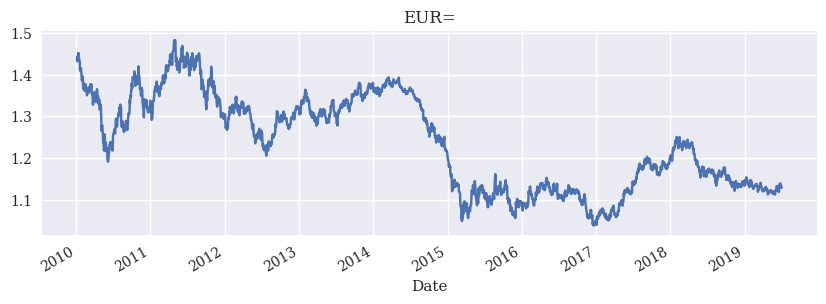

In [3]:
bb.plot_data()

## ML event based backtesting class

The `BacktestML` class extends the `BacktestBase` class from above. It is divided into 5 main sections, which are described further below:
*  Setting up all ML models to be tested
*  Preparing all features data, including the train/test split of the dataset
*  Training the models, including some vectorized backtesting output for validation
*  Running event-based backtesting using the models
*  Finally, the main method `run_ml_strategies` which orchestrates the process, based on some customizable input parameters

_**NOTE:** Please execute the cells below sequentially till after the cell with the `run_ml_strategies` method, since they build up the `BacktestML` class._


In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [5]:
class BacktestML(BacktestBase):
    
    models = None
    train_test_split_percentage = 0.70
    lags = 5
    base_features = []
    lagged_features = []
    
    def setup_models(self):
        print("Setting up ML models...")
        self.models = {'gauss': GaussianNB(),
                       'logreg': LogisticRegression(C=1, solver='lbfgs', max_iter=500),
                       'dtc': DecisionTreeClassifier(max_depth=7),
                       'svm': SVC(C=1, gamma='auto', kernel='linear'),
                       'mlp': MLPClassifier(hidden_layer_sizes=[64], shuffle=False,
                                max_iter=1000)}

The `prepare_features` method adds the necessary features data, then applies a Gausian normalization to this. For the Gausian normalization, the partition of the dataset which will be used for training is taken to calculate the mean and standard deviation (`mu` and `std`). The Gausian normalization is, however, applied to the entire dataset.

Some features are deliberately excluded from normalization (returns, direction, and directional bins based on returns).

Adding lags to the features data is done in a separate method `add_lags_to_features` to allow for more granular selection of lagged features to add. By default, all features are added.

In [6]:
class BacktestML(BacktestML):

    def prepare_features(self):
        print("Prepring features...")
        
        self.base_features = ['SMA1',
                              'SMA2',
                              'SMA_dif',
                              'EWMA1',
                              'EWMA2',
                              'EWMA_dif',
                              'VOLAT1',
                              'VOLAT2']
        SMA1 = 42  
        SMA2 = 127 
        EWMA1 = 15  
        EWMA2 = 55 
        VOLAT1 = 5  
        VOLAT2 = 21 
        
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()
        self.data['SMA_dif'] = self.data['SMA1'] - self.data['SMA2']
        self.data['EWMA1'] = self.data['price'].ewm(halflife=EWMA1).mean()
        self.data['EWMA2'] = self.data['price'].ewm(halflife=EWMA2).mean()
        self.data['EWMA_dif'] = self.data['EWMA1'] - self.data['EWMA2']
        self.data['VOLAT1'] = self.data['return'].rolling(VOLAT1).std()
        self.data['VOLAT2'] = self.data['return'].rolling(VOLAT2).std()
        self.data.dropna(inplace=True)
        
        # Apply train/test split, then calculate mu and std for normalization based on train data
        # Then apply calculated mu & std to feature columns of entire data set
        
        split = int(len(self.data) * self.train_test_split_percentage)
        train = self.data.iloc[:split]
        
        mu, std = train[self.base_features].mean(), train[self.base_features].std()
        self.data[self.base_features] -= mu
        self.data[self.base_features] /= std
        
        # Add additional features which should not be included in normalization: returns, direction, and directional bins based on returns
        
        self.data['d'] = np.where(self.data['return'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

        bins = [-0.025, -0.02, -0.015, -0.01, -0.005, 0.005, 0.01, 0.015, 0.02, 0.025,]
        self.data['d_bins'] = np.digitize(self.data['return'], bins=bins)

        self.base_features.extend(['return', 'd', 'd_bins'])

    def add_lags_to_features(self, columns=None):

        if columns is None:
            columns = self.base_features # All base features will have lags added
        
        print(f'Adding {self.lags} lags to features: {", ".join(columns)}')
        
        self.lagged_features = []        
        for col in columns: #self.base_features:
            for lag in range(1, self.lags + 1):
                col_ = col + f'_lag_{lag}'
                self.data[col_] = self.data[col].shift(lag)
                self.lagged_features.append(col_)
        self.data.dropna(inplace=True)

In [7]:
class BacktestML(BacktestML):
    
    def create_train_test_data_split(self):
        print(f'Creating training ({self.train_test_split_percentage*100:.0f}%) and testing ({(1-self.train_test_split_percentage)*100:.0f}%) data split...')
        
        split = int(len(self.data) * self.train_test_split_percentage)
        self.train_data = self.data.iloc[:split].copy()
        self.test_data = self.data.iloc[split:].copy()

The `fit_models` methodh as a few features:
*  It optionally allows for selection of best features (using ScikitLearn's SelectKBest module).
*  Models to be trained are selected using the `models_to_test` parameter, default being all models defined.
*  Models are then trained using the lagged features and direction as label
*  Directly after the training/fitting a vectorized backtest is run on the training and testing datasets
*  Text output is generated of the backtest performance

In [8]:
class BacktestML(BacktestML):

    def fit_models(self, select_k_best=True, select_k=15, models_to_test=None):
        print("Fitting models to training data...")
        if select_k_best is True:
            select_k = min(len(self.lagged_features), select_k) # ensure that k is not larger than actual number of features
            selector = SelectKBest(f_classif, k=select_k)
            cols_sel = selector.fit(self.train_data[self.lagged_features], self.train_data['d']).get_support(indices=True)
            self.lagged_features = self.train_data[self.lagged_features].columns[cols_sel]
            # print(f"SelectKBest cols: {self.lagged_features}")
            print(f"Selecting {select_k} best features...")
        
        if models_to_test is None:
            models_to_test = self.models 
        for m in models_to_test:
            model = self.models[m]
            model.fit(self.train_data[self.lagged_features], self.train_data['d'])
            
            # Complete in-sample performance calcs
            self.train_data['p_' + m] = model.predict(self.train_data[self.lagged_features])
            self.train_data['p_' + m] = np.where(self.train_data['p_' + m] == 1, 1, -1)
            self.train_data['s_' + m] = self.train_data['p_' + m] * self.train_data['return']
            perf_train = self.train_data[['return', 's_' + m]].sum().apply(np.exp)

            # Complete out-of-sample performance calcs
            self.test_data['p_' + m] = model.predict(self.test_data[self.lagged_features])
            self.test_data['p_' + m] = np.where(self.test_data['p_' + m] == 1, 1, -1)
            self.test_data['s_' + m] = self.test_data['p_' + m] * self.test_data['return']
            perf_test = self.test_data[['return', 's_' + m]].sum().apply(np.exp)

            print(f"Model {m}:")
            print(f"   In-sample: Buy-and-hold returns:      {perf_train[0]:.2f}")
            print(f"   In-sample: Model returns:             {perf_train[1]:.2f}")
            print(f"   Out-of-sample: Buy-and-hold returns:  {perf_test[0]:.2f}")
            print(f"   Out-of-sample: Model returns:         {perf_test[1]:.2f}")
    
            #self.train_data[['return', 's_' + m]].cumsum().apply(np.exp).plot(title=f'{self.symbol} | {m} | in-sample')
            
            #plt.figure(figsize=(15, 5))
            #plt.plot(self.train_data['return'].cumsum().apply(np.exp), lw=1.5, label=f'Buy-and-hold returns: {round(float(perf[0]),2)}')
            #plt.plot(self.train_data['s_' + m].cumsum().apply(np.exp), lw=1.5)#, label=f'Strategy returns: {round(float(perf[1]),2)}')
            #plt.ylabel('Returns')
            #plt.title(f'{self.symbol} | {m} | in-sample')

The `backtest_ml_model` performs an event based backtest for a **single model** and **single dataset** (for example, training or testing data)

In [9]:
class BacktestML(BacktestML):
            
    def backtest_ml_model(self, bt_data, model, model_name):
        start_date = str(bt_data.index[0])[:10]
        end_date = str(bt_data.index[len(bt_data)-1])[:10]
        
        msg = f"Running ML strategy: {model_name} | {self.symbol}"
        msg += f'\nDate range: {start_date} - {end_date}'
        msg += f'\nfixed costs {self.ftc:.2f} | '
        msg += f'proportional costs {(self.ptc*100):.2f}%'
        print(msg)        
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_amount  # reset initial capital
        
        for bar in range(0, len(bt_data)):
            date, price = self.get_date_price(bar)
            position = 1 if model.predict(bt_data[self.lagged_features])[bar] == 1 else -1
            
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar-1, units=-self.units)
                self.place_buy_order(bar-1,
                                     amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar-1, units=self.units)
                self.place_sell_order(bar-1,
                                      amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
         
        self.close_out(bar)

The `run_ml_strategies` method is the main method used to orchestrate preparation of all data and models required to run the backtest:
*  A user has the option to override the test/training data split percentage, lags used and specific models to test (instead of all defined models)
*  Additionally a user can choose to only run a vectorized backtest, useful during the initial feature and model definition
*  Finally, the user is able to select whether `SelectKBest` should be used to select the best features (and how many of these)

In [10]:
class BacktestML(BacktestML):
            
    def run_ml_strategies(self, train_test_split_percentage=0.7, lags=5,
                          vec_bt_only=False, select_k_best=False, select_k=15,
                          models_to_test=None):
        
        self.train_test_split_percentage = train_test_split_percentage
        self.lags = lags
        
        # Setup models to be included in backtest
        self.setup_models()
        if models_to_test is None:
            models_to_test = self.models

        # Prepare a fresh dataset
        self.get_data()
        
        # Prepare features data
        print('\n' + '#' * 57)
        print('## FEATURE PREPARATION #')
        print('#' * 57)
        self.prepare_features()
        print(f'Base features: {", ".join(self.base_features)}')
        self.add_lags_to_features()

        # Only do train/test split of data after all features have been added and normalised
        self.create_train_test_data_split()
        
        # Fit and validate (using vectorized backtesting) models with training and test data 
        print('\n' + '#' * 57)
        print('## MODEL FITTING TO TRAINING DATASET #')
        print('#' * 57)
        self.fit_models(select_k_best=select_k_best, select_k=select_k, models_to_test=models_to_test)

        # Do event based backtesting of selected models, unless this was explicitly disabled
        if vec_bt_only is not True:
            print('\n' + '#' * 57)
            print('## EVENT BASED BACKTESTING FOR SELECTED MODELS #')
            print('#' * 57)
            for m in models_to_test:
                
                #print('=== IN-SAMPLE =======')
                #print('=====================')
                #self.active_backtest_dataset = self.train_data
                #self.backtest_ml_model(self.active_backtest_dataset, self.models[m], m)
                print('=====================')
                print('=== OUT-OF-SAMPLE ===')
                print('=====================')
                self.active_backtest_dataset = self.test_data
                self.backtest_ml_model(self.active_backtest_dataset, self.models[m], m)
                
    

## Usage

Enstantiate an instance of the `BacktestML` class, specifying the symbol to test, transaction costs and initial amount.

`start` and `end` dates are optional. If any of these are omitted, the start and end of the dataset is assumed respectively.

A graph of the instrument's price can viewed using the `plot_data` method

In [11]:
# Symbols: ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX', 'EUR=', 'XAU=', 'GDX', 'GLD']
mlbt = BacktestML("GDX", amount=10000, ftc=3, verbose=False, start='2010-01-01', end='2016-12-31')

Loading data from disk...


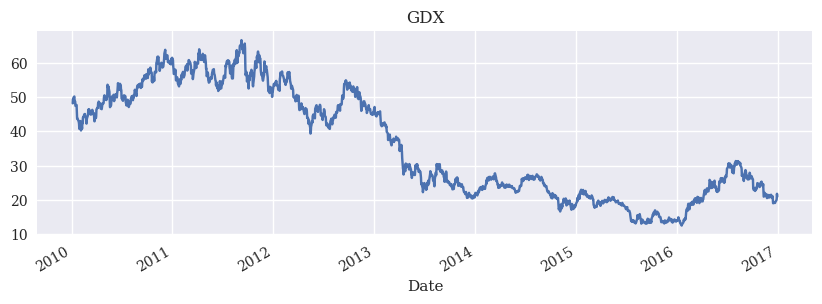

In [12]:
mlbt.plot_data()

Once an instance of the `BacktestML` class is instantiated, the `run_ml_strategies` method is used to run a backtest.

As described above for the `run_ml_strategies`, the `run_ml_strategies` can take parameters to influence how the backtest is performed. 4 examples are shown below:
1. Running a default backtest (with default parameters)
2. Running a default backtest, but selecting the 20 best features
3. Running a default backtest, but with 3 models only (`gauss`, `logreg` and `svm`)
4. Running a default backtest, but electing the 20 best features and using 3 models only (`gauss`, `logreg` and `svm`)

In [13]:
mlbt.run_ml_strategies()

Setting up ML models...

#########################################################
## FEATURE PREPARATION #
#########################################################
Prepring features...
Base features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Adding 5 lags to features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Creating training (70%) and testing (30%) data split...

#########################################################
## MODEL FITTING TO TRAINING DATASET #
#########################################################
Fitting models to training data...
Model gauss:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             6.71
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample: Model returns:         1.86
Model logreg:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             21.70
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample

In [14]:
mlbt.run_ml_strategies(select_k_best=True, select_k=20)

Setting up ML models...

#########################################################
## FEATURE PREPARATION #
#########################################################
Prepring features...
Base features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Adding 5 lags to features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Creating training (70%) and testing (30%) data split...

#########################################################
## MODEL FITTING TO TRAINING DATASET #
#########################################################
Fitting models to training data...
Selecting 20 best features...
Model gauss:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             4.50
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample: Model returns:         1.32
Model logreg:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             4.47
   Out-of-sample: Buy-and-hold re

/Users/ll/miniconda3/envs/cpf_ml_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model mlp:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             438038.19
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample: Model returns:         1.82

#########################################################
## EVENT BASED BACKTESTING FOR SELECTED MODELS #
#########################################################
=== OUT-OF-SAMPLE ===
Running ML strategy: gauss | GDX
Date range: 2015-01-26 - 2016-12-30
fixed costs 3.00 | proportional costs 0.00%
Final balance                 [$] 10393.62
Market Performance            [%] -5.55
Strategy Net Performance      [%] 3.94
Market Performance Annualised [%] -2.86
Strategy Net Perf. Annualised [%] 2.03
Number of trades              [#] 364
Avg. # trades per day         [#] 0.7
=== OUT-OF-SAMPLE ===
Running ML strategy: logreg | GDX
Date range: 2015-01-26 - 2016-12-30
fixed costs 3.00 | proportional costs 0.00%
Final balance                 [$] 11163.54
Market Performance            [%] -5.55
Str

In [15]:
mlbt.run_ml_strategies(models_to_test=['gauss','logreg','svm'])

Setting up ML models...

#########################################################
## FEATURE PREPARATION #
#########################################################
Prepring features...
Base features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Adding 5 lags to features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Creating training (70%) and testing (30%) data split...

#########################################################
## MODEL FITTING TO TRAINING DATASET #
#########################################################
Fitting models to training data...
Model gauss:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             6.71
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample: Model returns:         1.86
Model logreg:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             21.70
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample

In [16]:
mlbt.run_ml_strategies(select_k_best=True, select_k=20, models_to_test=['gauss','logreg','svm'])

Setting up ML models...

#########################################################
## FEATURE PREPARATION #
#########################################################
Prepring features...
Base features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Adding 5 lags to features: SMA1, SMA2, SMA_dif, EWMA1, EWMA2, EWMA_dif, VOLAT1, VOLAT2, return, d, d_bins
Creating training (70%) and testing (30%) data split...

#########################################################
## MODEL FITTING TO TRAINING DATASET #
#########################################################
Fitting models to training data...
Selecting 20 best features...
Model gauss:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             4.50
   Out-of-sample: Buy-and-hold returns:  0.96
   Out-of-sample: Model returns:         1.32
Model logreg:
   In-sample: Buy-and-hold returns:      0.43
   In-sample: Model returns:             4.47
   Out-of-sample: Buy-and-hold re